In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

In [3]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# read the matadata csv
nifty_meta = pd.read_csv('data/nifty_meta.csv')
nifty_meta.head(2)

,Company Name,Industry,Symbol,Series,ISIN Code
0,ACC Ltd.,CEMENT & CEMENT PRODUCTS,ACC,EQ,INE012A01025
1,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042


In [5]:
# get the ticker list with industry is equal to FINANCIAL SERVICES
tickers = list(nifty_meta[nifty_meta.Industry=='FINANCIAL SERVICES'].Symbol)
print(tickers)
print(len(tickers))
# start and end dates for backtesting
fromdate = datetime.datetime(2010, 1, 1)
todate = datetime.datetime(2020, 6, 15)
# read back the pricing data
prices = pd.read_csv('data/prices.csv', index_col=['ticker','date'], parse_dates=True)
prices.head(2)

['AXISBANK', 'BAJFINANCE', 'BAJAJFINSV', 'BAJAJHLDNG', 'BANDHANBNK', 'BANKBARODA', 'GICRE', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HDFC', 'ICICIBANK', 'ICICIGI', 'ICICIPRULI', 'IBULHSGFIN', 'INDUSINDBK', 'KOTAKBANK', 'L&TFH', 'PEL', 'PFC', 'PNB', 'SBILIFE', 'SRTRANSFIN', 'SBIN', 'NIACL']
25


/var/folders/4r/l886k45s0_l30d_d6cnz284c0000gn/T/ipykernel_40122/1691210450.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prices = pd.read_csv('data/prices.csv', index_col=['ticker','date'], parse_dates=True)


open        high         low       close
ticker   date                                                      
AXISBANK 2010-01-04  198.779999  199.990005  197.619995  140.712021
         2010-01-05  199.600006  204.000000  199.139999  143.647934

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38580 entries, ('AXISBANK', Timestamp('2010-01-04 00:00:00')) to ('SRTRANSFIN', Timestamp('2020-06-15 00:00:00'))
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    38579 non-null  float64
 1   high    38579 non-null  float64
 2   low     38579 non-null  float64
 3   close   38579 non-null  float64
dtypes: float64(4)
memory usage: 1.4+ MB
15
['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA', 'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL', 'PFC', 'PNB', 'SBIN', 'SRTRANSFIN']
[('AXISBANK', 'PEL'), ('AXISBANK', 'SRTRANSFIN'), ('BAJAJFINSV', 'HDFCBANK'), ('BAJAJFINSV', 'INDUSINDBK'), ('BAJAJFINSV', 'KOTAKBANK'), ('BAJAJHLDNG', 'ICICIBANK'), ('BAJAJHLDNG', 'SBIN'), ('BAJFINANCE', 'KOTAKBANK'), ('BANKBARODA', 'ICICIBANK'), ('BANKBARODA', 'SBIN'), ('BANKBARODA', 'SRTRANSFIN'), ('ICICIBANK', 'PEL'), ('ICICIBANK', 'SBIN'), ('INDUSINDBK', 'KOT

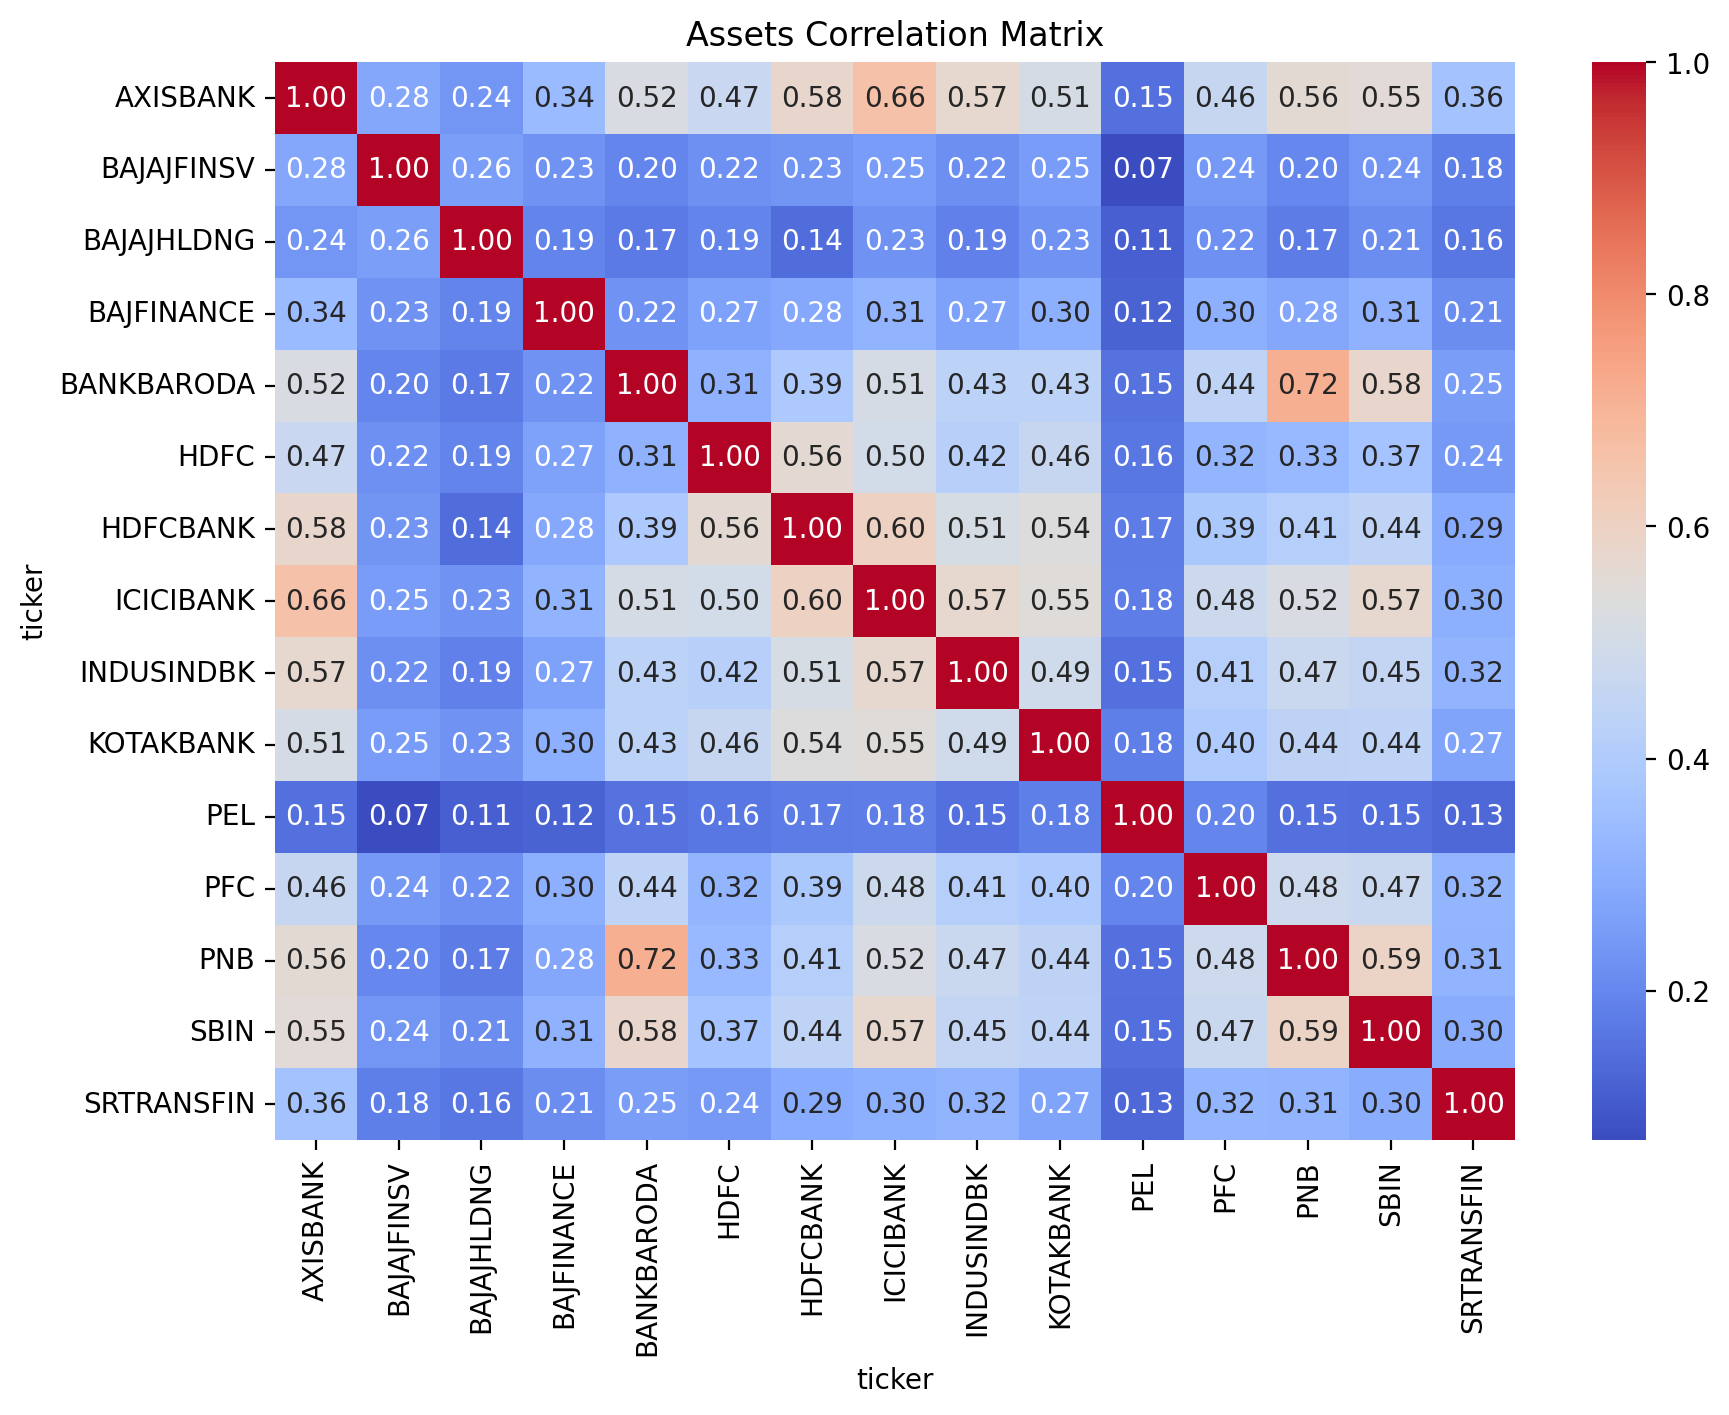

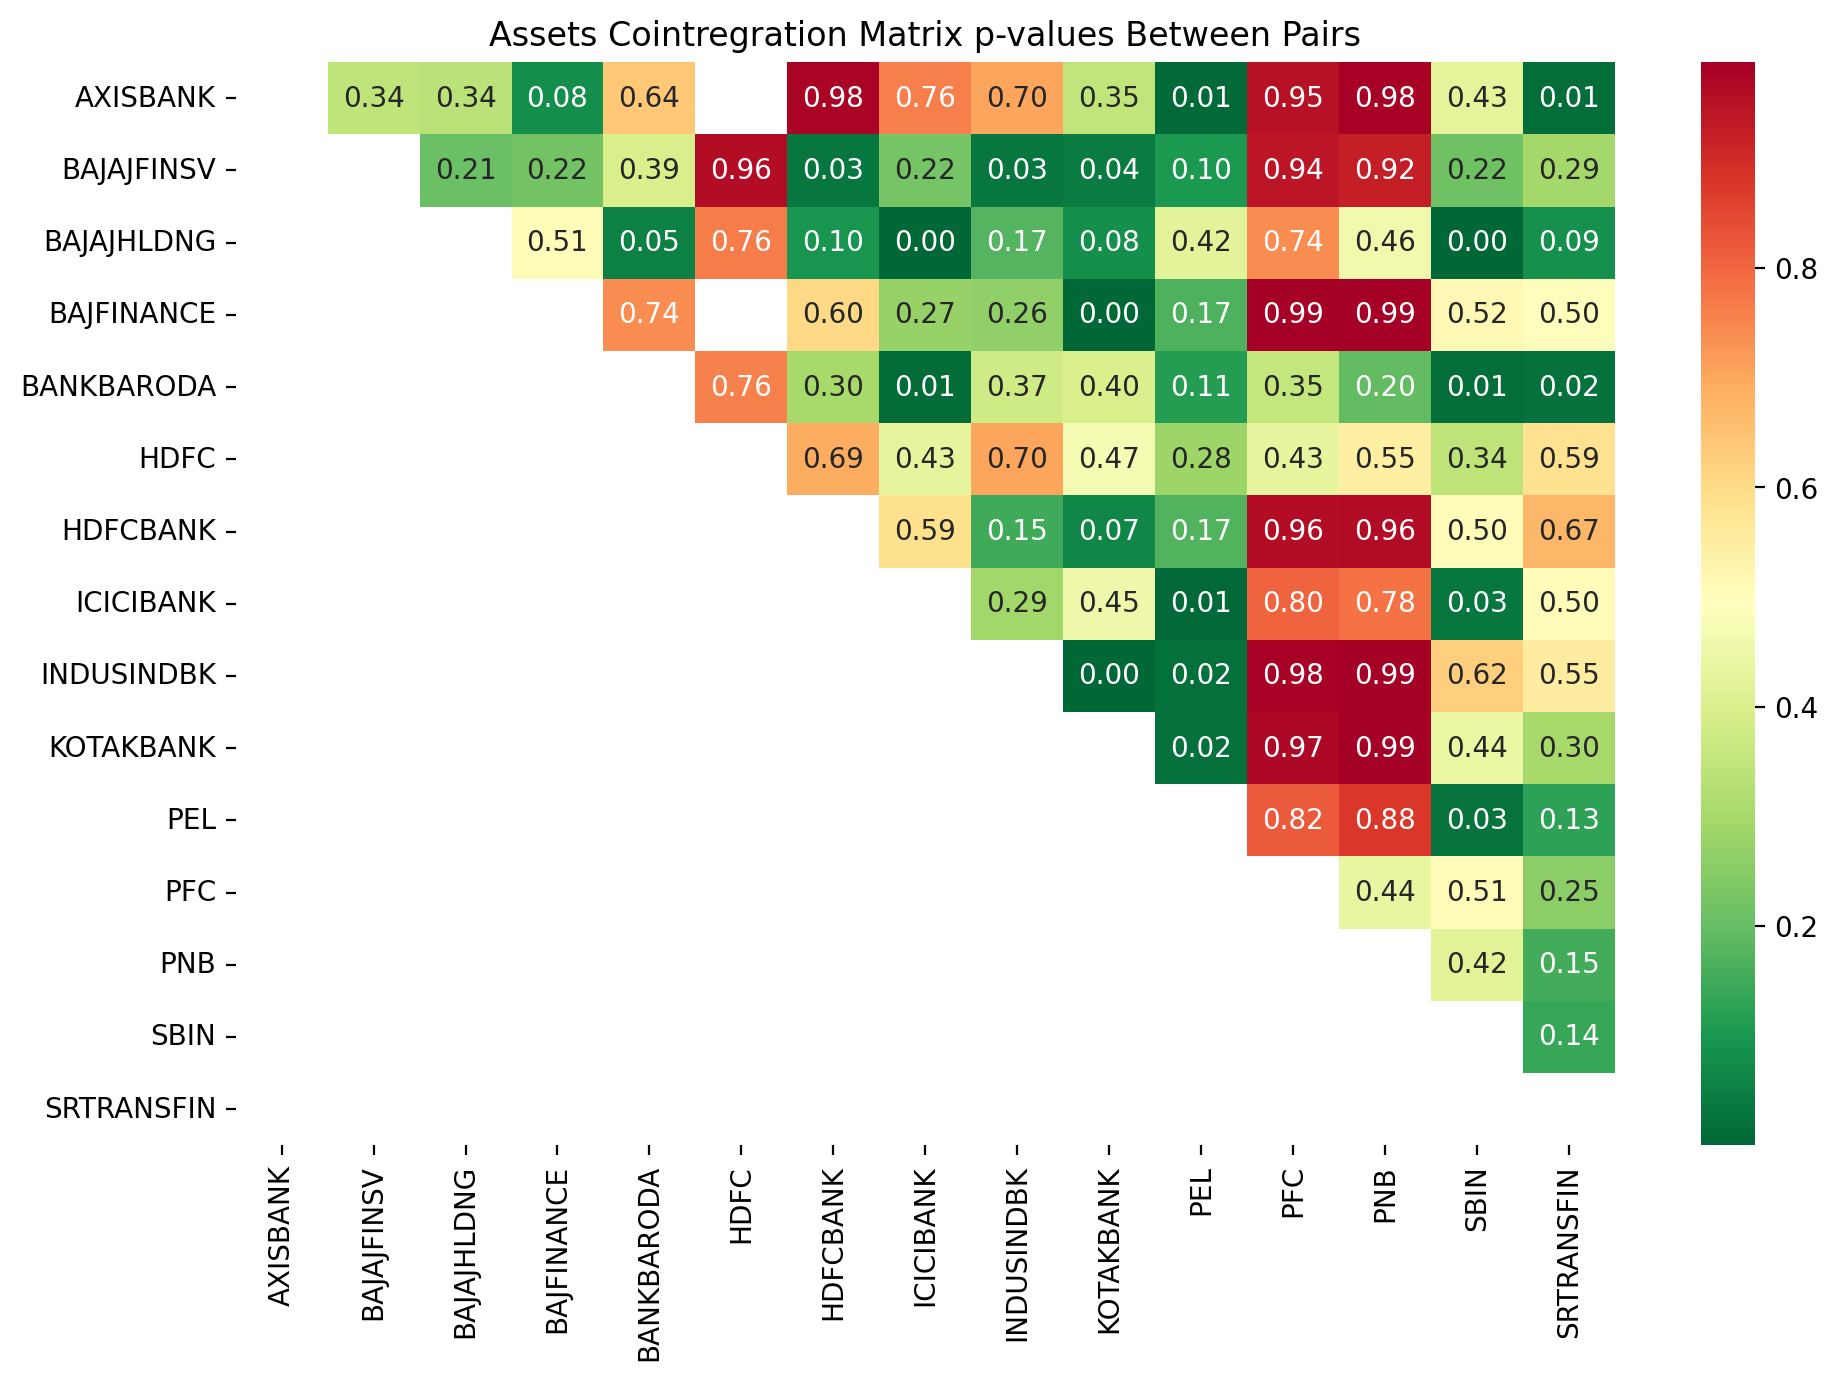

In [8]:
# remove tickers where we have less than 10 years of data.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
prices = prices.loc[idx[keep,:], :]
prices.info()
# final tickers list
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(len(TICKERS))
print(TICKERS)
# unstack and take close price
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()
close.head(2)
# train test split 
train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)
# quick view of head and tail of train set
#train_close.head(2).append(train_close.tail(2))
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('images/chart1', dpi=300)
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('images/chart2', dpi=300)

/var/folders/4r/l886k45s0_l30d_d6cnz284c0000gn/T/ipykernel_40122/3512559276.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Hedge Ratio =  1.4046459680586494
Critical Value =  -3.4590476442921605
{'1%': -3.435457117423131, '5%': -2.863795358068796, '10%': -2.567970771161219}


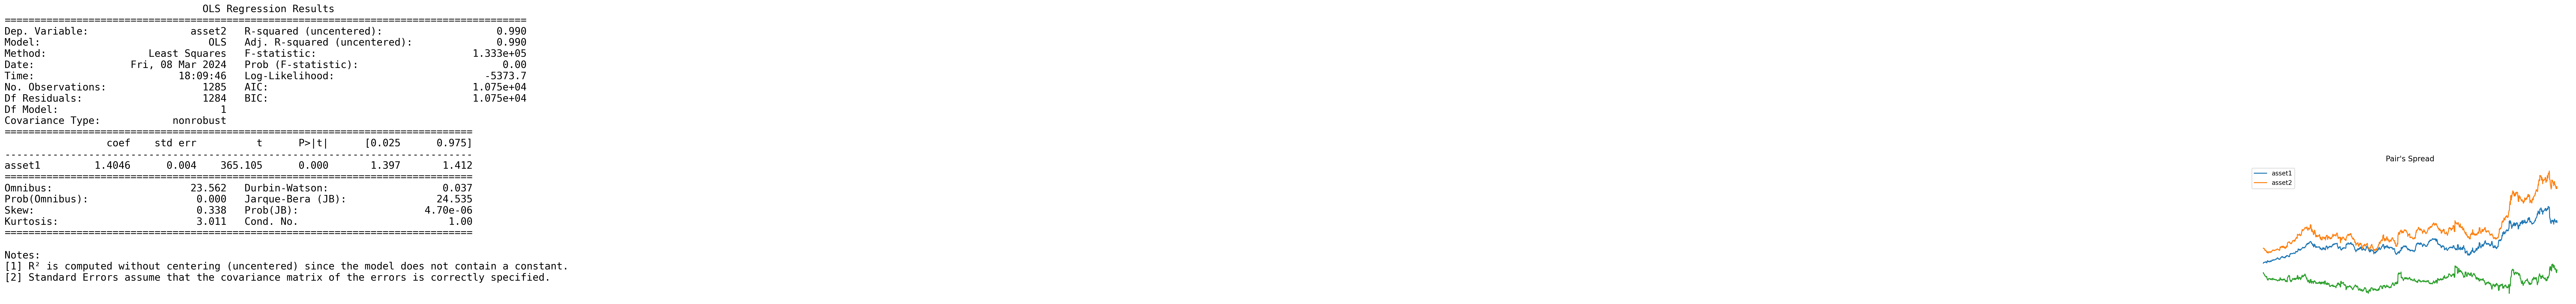

In [10]:
# final pair to test strategy
asset1 = 'BANKBARODA'
asset2 = 'SBIN'
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
plt.savefig('images/chart3', dpi=300)
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('images/chart4', dpi=300);
print('Hedge Ratio = ', model.params[0])
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])
# probablity critical values
print(adf[4])

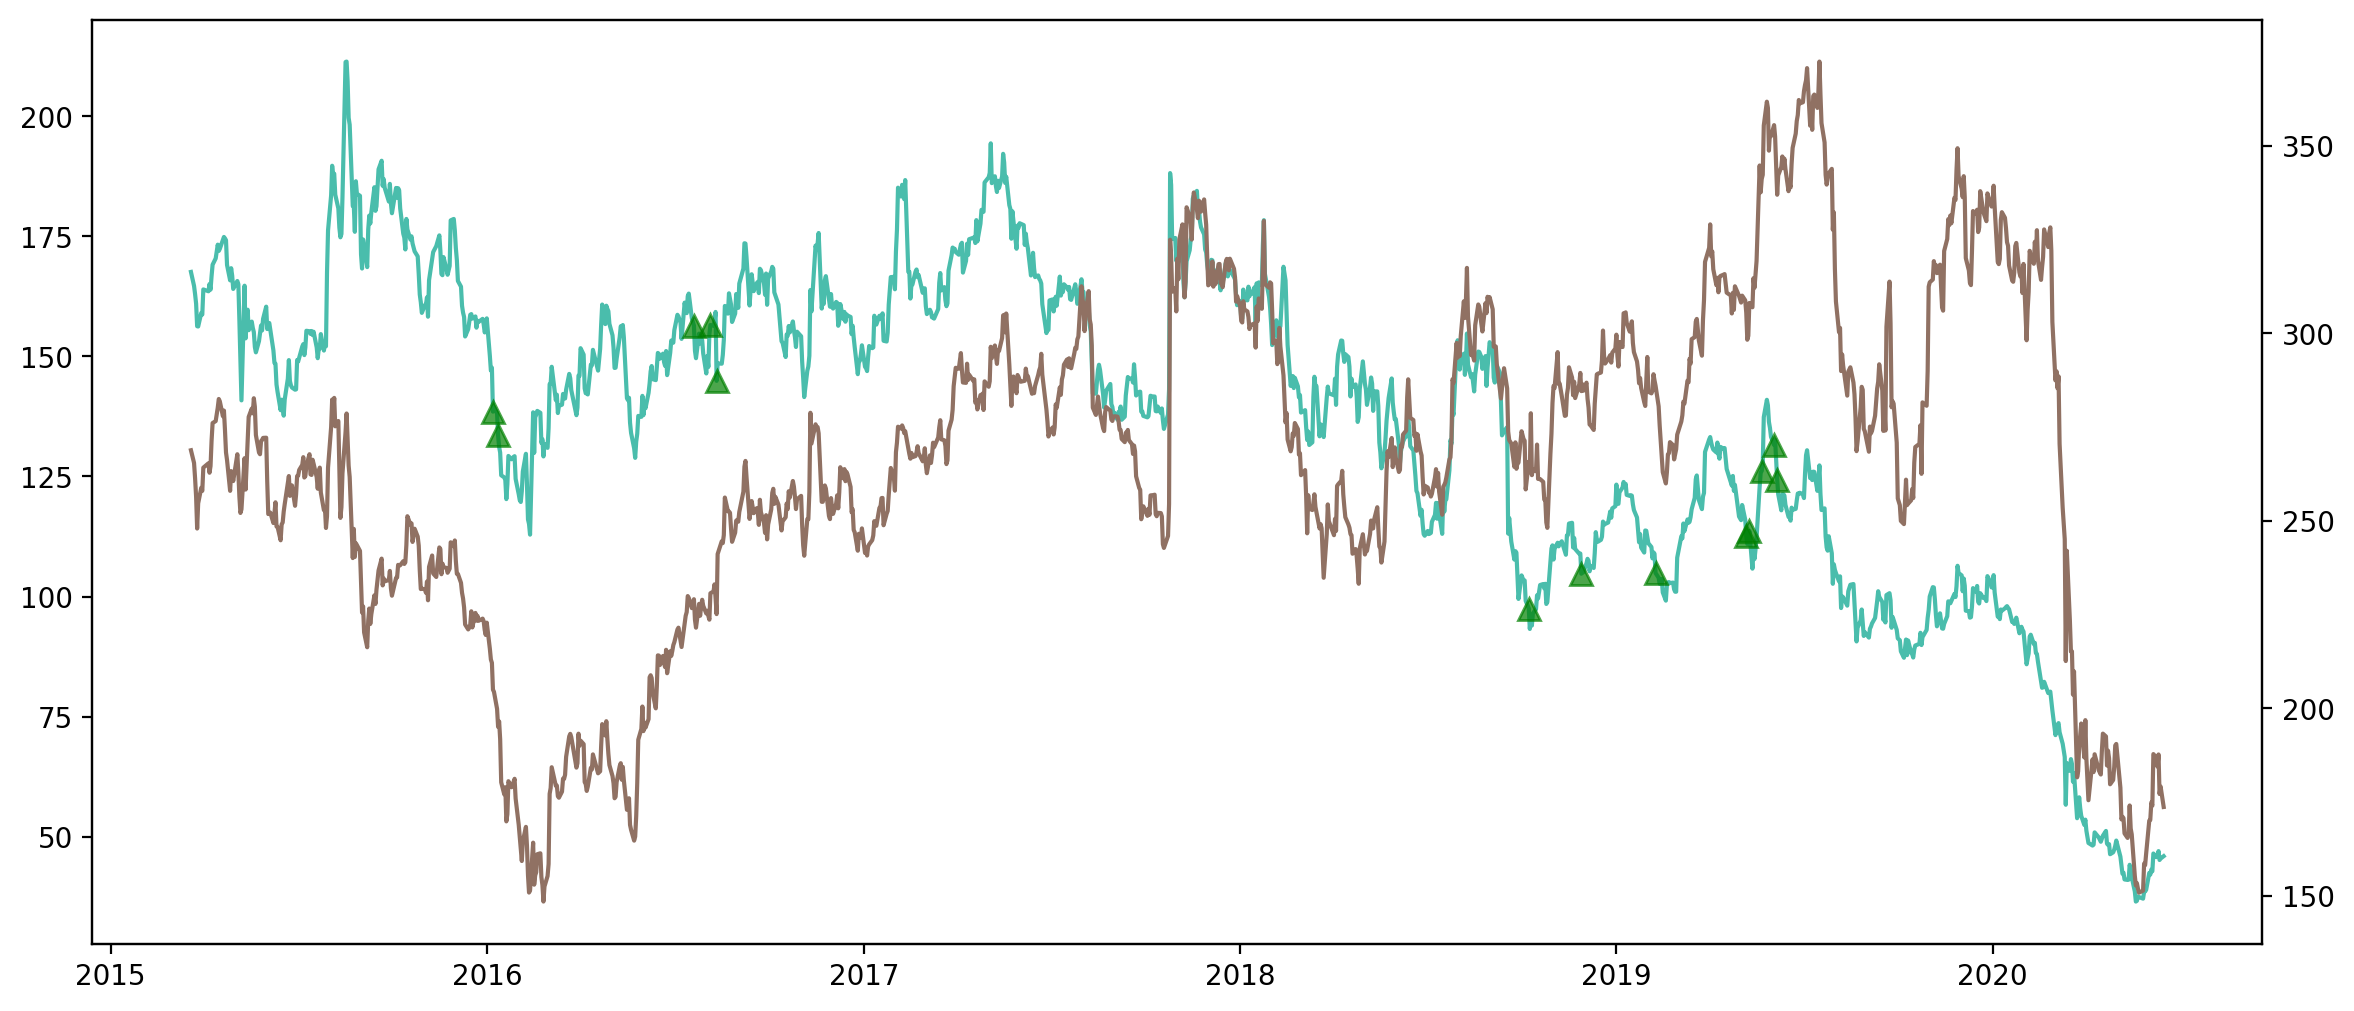

In [13]:
# calculate z-score
def zscore(series):
 return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()
# verify datafame head and tail
#signals.head(3).append(signals.tail(3))
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()
#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

Number of days =  1910
CAGR = 16.515%


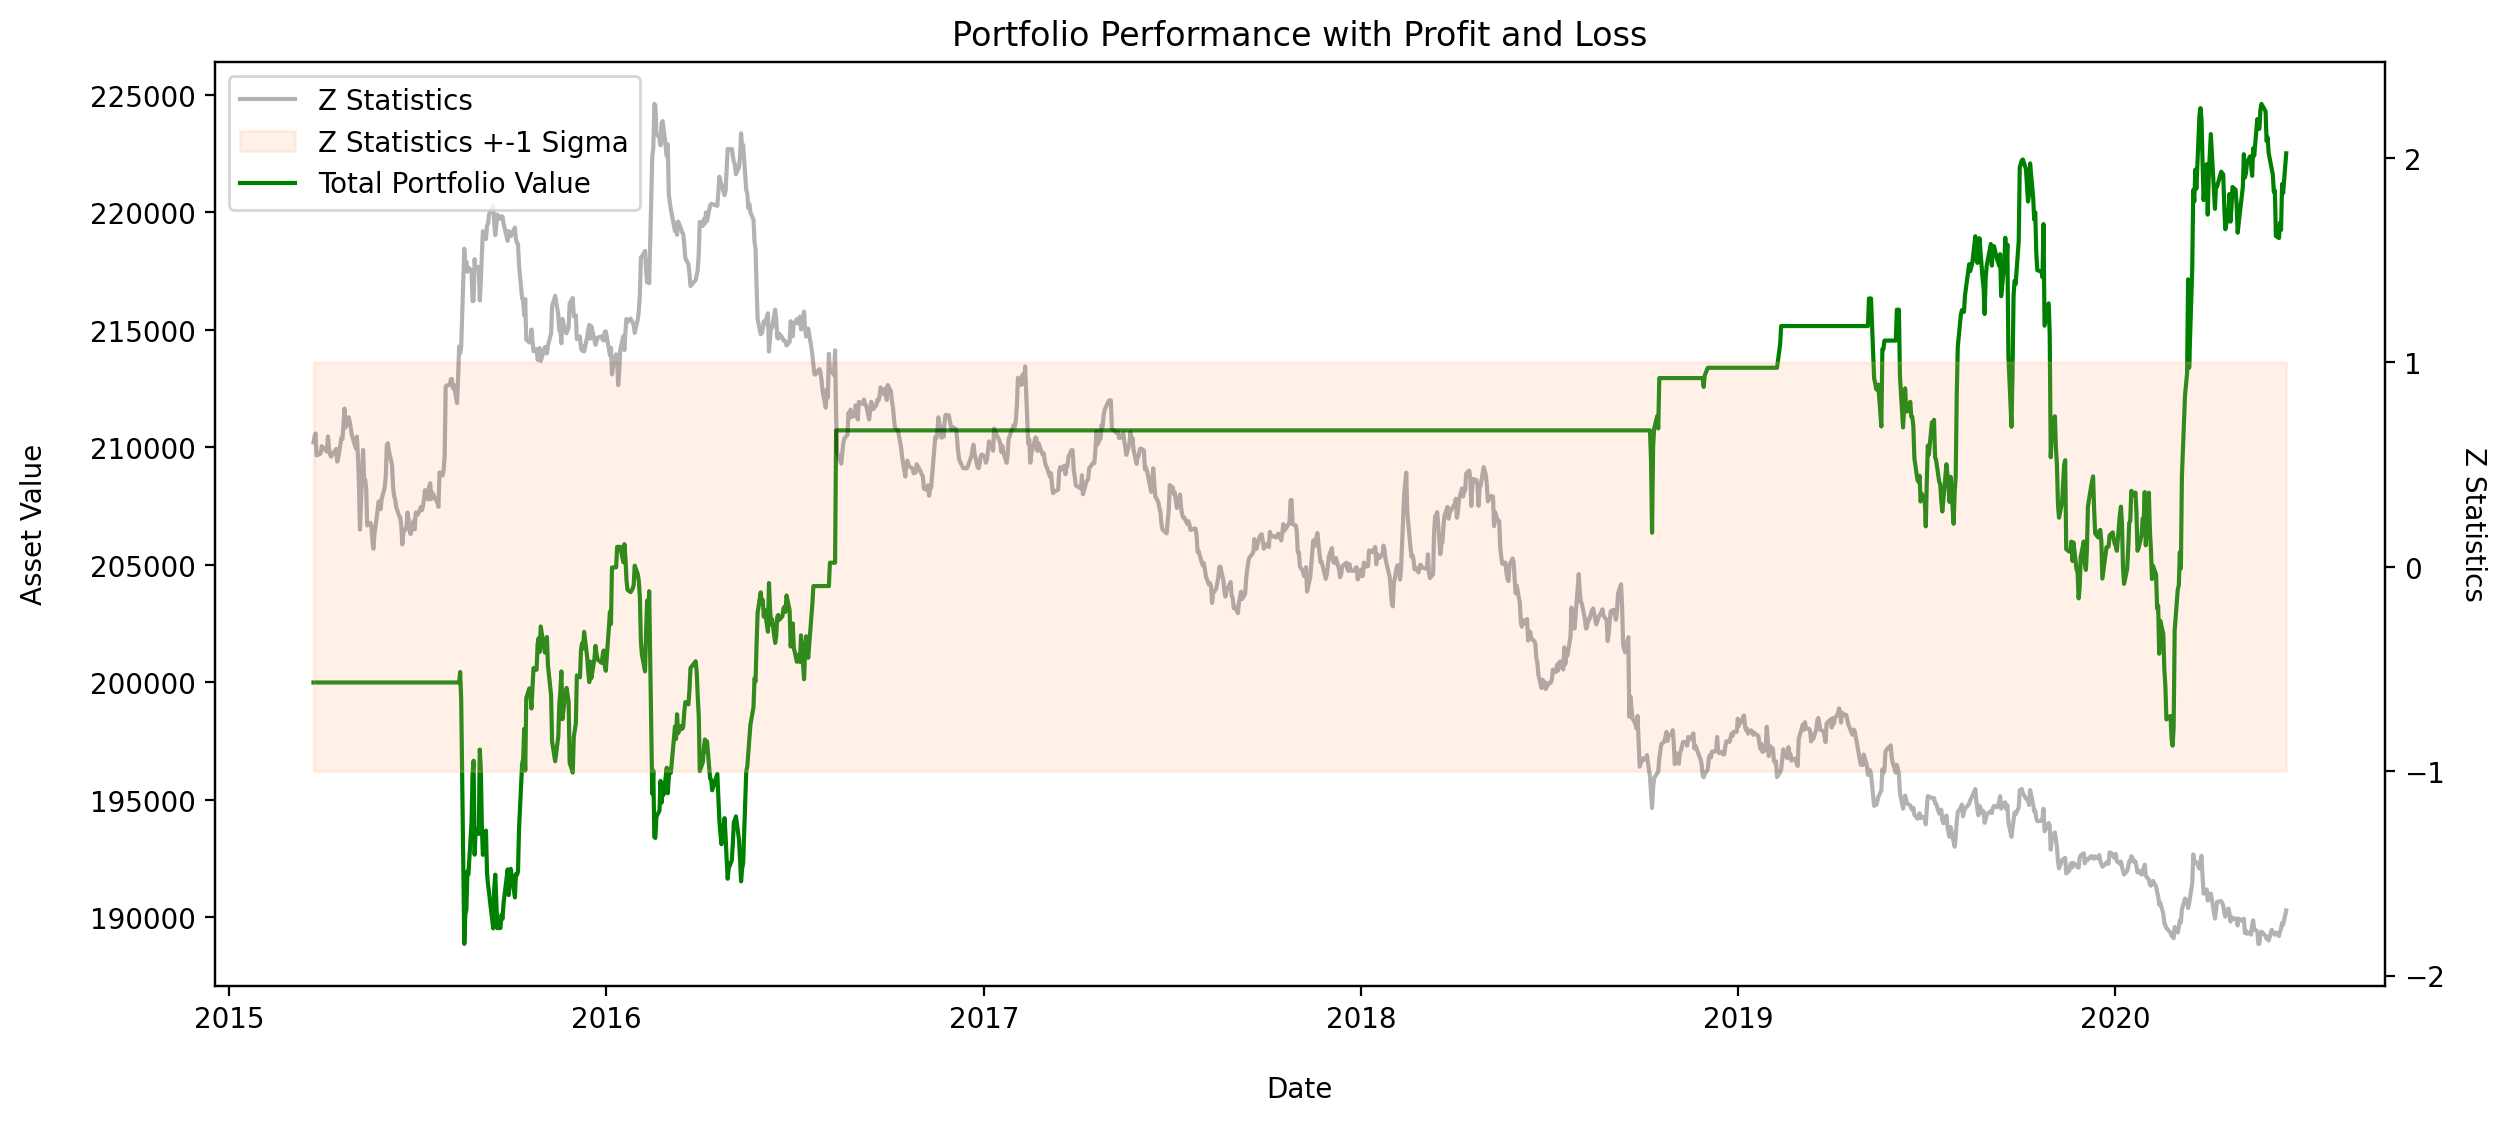

In [14]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('images/chart8', dpi=300);

# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))